In [1]:
%reload_ext autoreload
%autoreload 2
import pipeline
import explore as e
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import loops as l
from sklearn.model_selection import ParameterGrid

### Load and Process Data

In the following lines, I call pipeline.process() to load the data and store it as the variable df of type dataframe. I then change the datatypes of the date_posted and datefullyfunded columns to datetime. The goal of this analysis is to predict projects that will not be funded in 60 days,so I created our target column, labeled as 'not_funded_in_60', and assign a 1 if the project was not funded within 60 days of posting and 0 otherwise. I also create two columns, year_posted and month_posted, so that I can take into account temporal changes across months and years. I create my features when making my test and train datasets. At this stage I call the get_train_test_splits() function in pipeline.py, which identifies categorical columns, makes dummy variables, and imputes data from continuous variables in both test and train datasets. Finally, I discretize two continuous variables, students_reached and total_price_including_optional_support, into four distinct bins 'low', 'med', 'high', and 'extreme'.

In [2]:
pipe = pipeline.process(pipeline.path)
df = pipe.data

In [3]:
## Change date types 
df['date_posted'] = pd.to_datetime(df['date_posted'])
df['datefullyfunded'] = pd.to_datetime(df['datefullyfunded'])
df['year_posted'], df['month_posted'] = df['date_posted'].dt.year, df['date_posted'].dt.month

In [4]:
### Make Target Column
df['diff'] = (df['datefullyfunded'] - df['date_posted']).dt.days
df['not_funded_in_60'] = np.where(df['diff'] > 60, 1, 0)

#### Handle Nulls

The following matrix visualizes location of missing records by index. This enables us to determine if missing records occur randomnly or are bunched together. Variation in both secondary_focus_area and secondary_focus_subject do not appear to be missing at random -- the same records seem to have missing values for both columns. The bar chart displays which columns have missing records and the total number of records missing. I drop all records with null values for categorical variables that I intend to include in my list of features. For the two continuous variables I plan to include, students_reached and total_price_including_optional_support, I impute the median for all null values after splitting into dataset into test and train for each time period.

In [5]:
### Confirming that each row is a unique project id -- number of rows in df is equal to number if unique project ids 
df['projectid'].nunique() == df.shape[0]

True

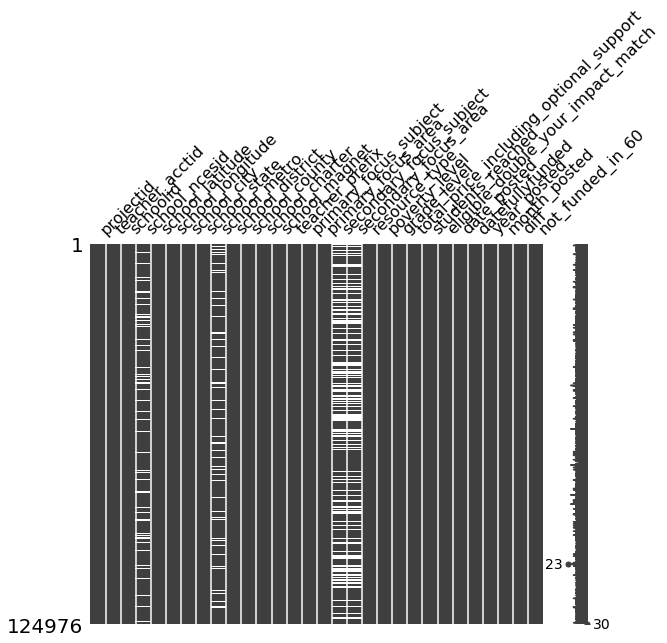

In [6]:
e.missing_matrix(df)

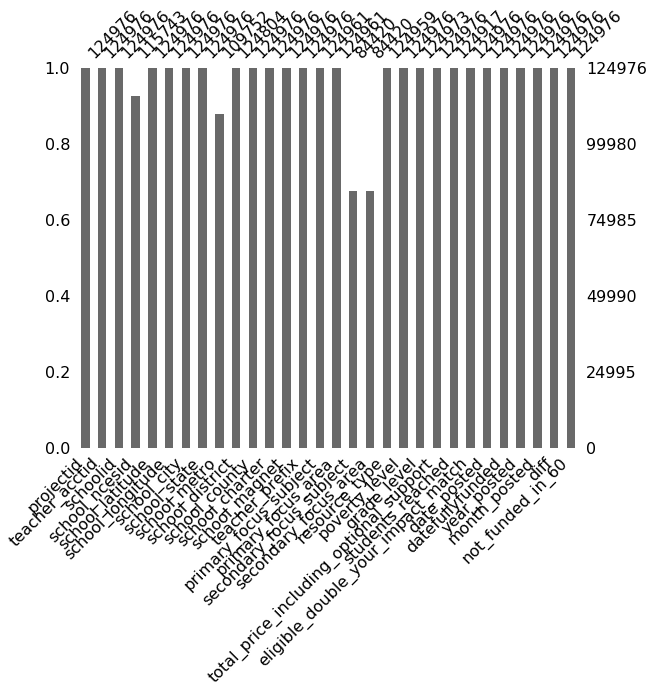

In [7]:
e.missing_bar(df)

### Data Exploration

#### Distributions

Using a variety of plot types -- density plots, box plots, and linecharts, and bar charts -- I explored the distributions of several variables as well as distribution of variables by year and outcome in order to see if certain features are more likely to occur in certain time periods.

As we can see in both the distribution of students_reached and total_price_including_optional_support, our continuous variables are influenced by extreme outliers. The mean (92.46) of the number of students_reached is nearly equivalent to the value for the 75th percentile (90.0), and there are records with values 8 standard deviations away from the mean. Total_price_including_optional_support has an even longer tail, with values 70 standard deviations from the mean. The following are a serious of bar charts, the first of which visualizes the total number of projects posted grouped by their poverty level. For both years, the there were more projects listed as highest poverty than any other category, and over the course of both years more than half of all projects were listed as highest poverty. Following bar chart shows that largest number of projects are posted from teachers in California for both 2012 and 2013. In box plot of project cost by poverty level, one interesting thing to note is that median cost for both years was highest mong projects classifed as 'low_poverty'

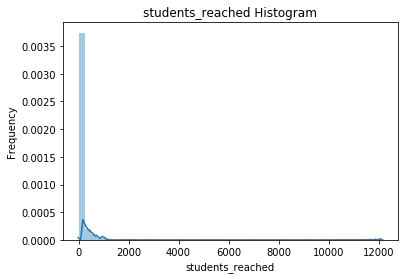

In [19]:
e.make_histogram(df, 'students_reached')

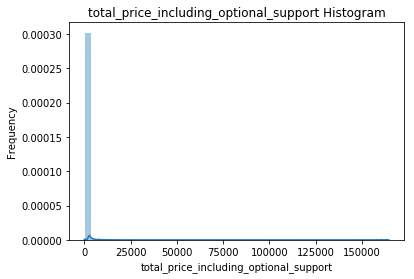

In [20]:
e.make_histogram(df, 'total_price_including_optional_support')

In [21]:
# Number of teachers with 10+ projects
len(df.groupby('teacher_acctid').filter(lambda x: len(x) > 10).groupby('teacher_acctid').size())

539

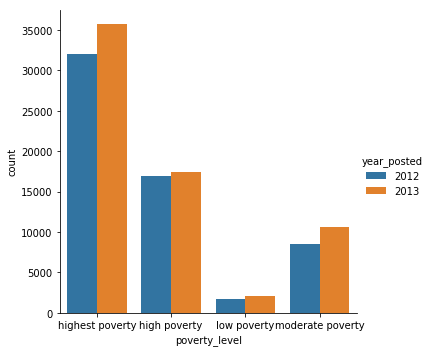

In [22]:
sns.catplot(x='poverty_level', hue='year_posted', kind='count', data=df)

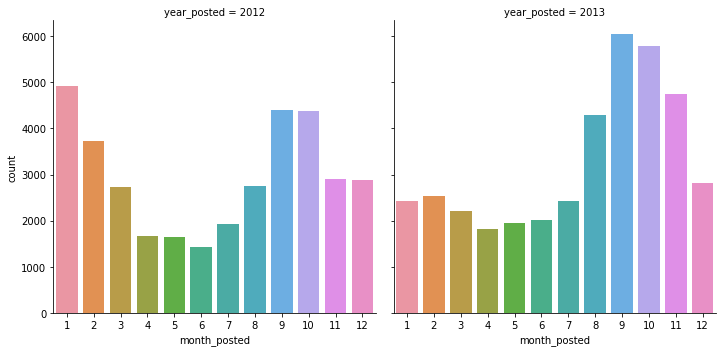

In [19]:
sns.catplot(x='month_posted', col='year_posted', kind='count', data=df)

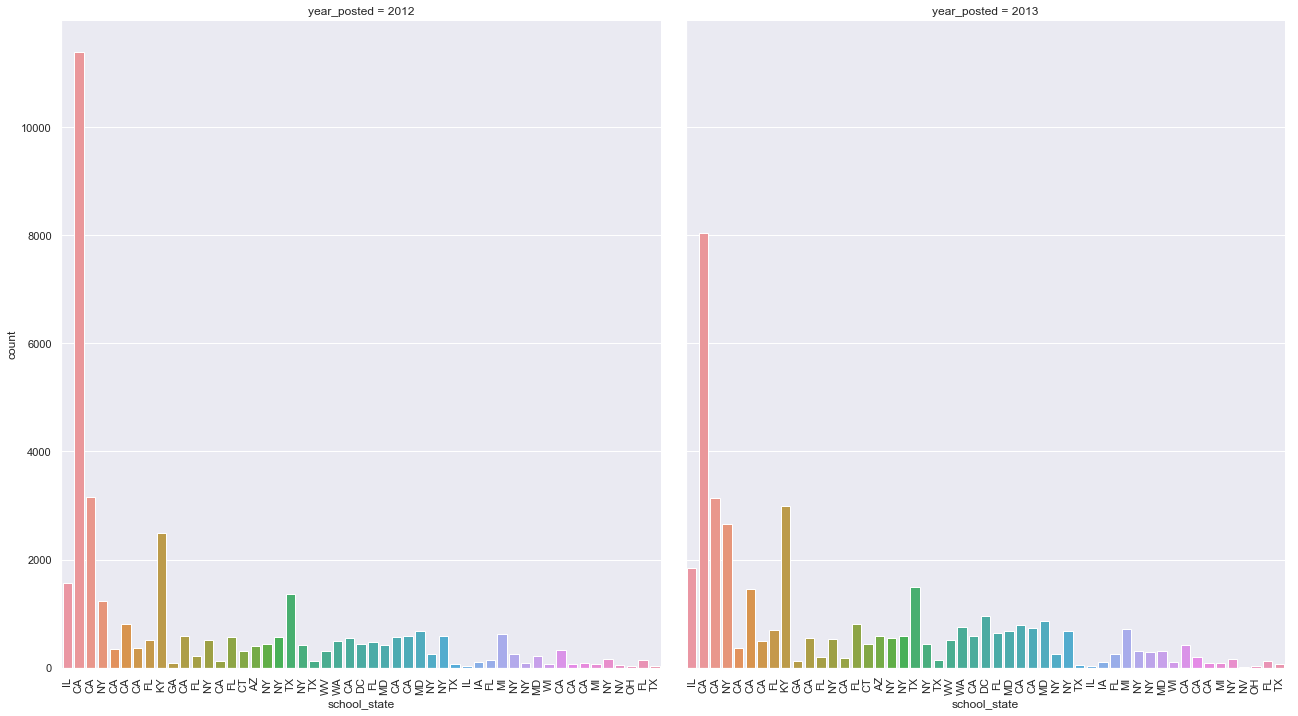

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.catplot(x='school_state', col='year_posted', kind='count', data=df, height=10, aspect=.9)
ax.set_xticklabels(df['school_state'], rotation=90)

In [23]:
project_counts = df.groupby(['year_posted', 'not_funded_in_60']).projectid.nunique()
project_counts

year_posted  not_funded_in_60
2012         0                   42584
             1                   16640
2013         0                   46382
             1                   19370
Name: projectid, dtype: int64

In [24]:
df['not_funded_in_60'].mean()

0.2881353219818205

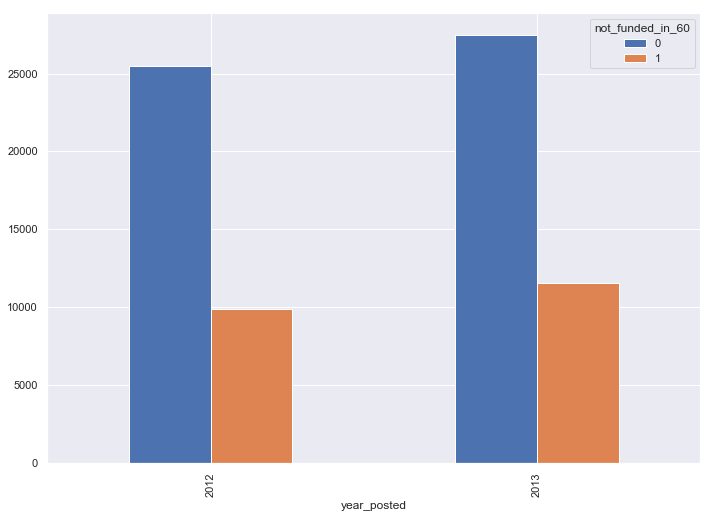

In [18]:
### Total count of projects per year grouped by outcome
ax = df.groupby(['year_posted', 'not_funded_in_60']).projectid.nunique().unstack().plot(kind='bar')

In [19]:
df_by_year = df.groupby(['month_posted','year_posted','not_funded_in_60']).size().to_frame('count').reset_index()

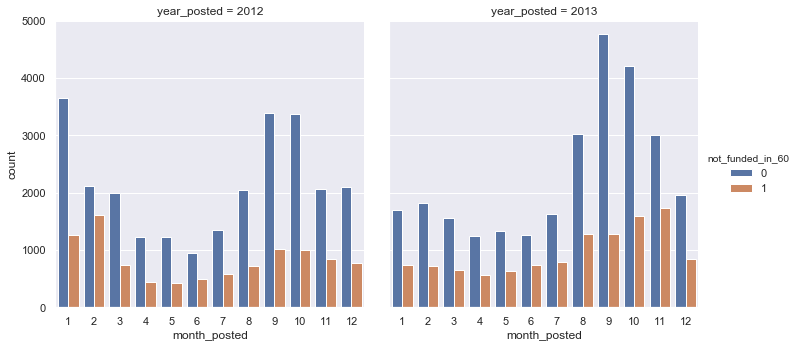

In [20]:
sns.catplot(x='month_posted', col='year_posted', y='count', hue='not_funded_in_60', kind='bar', data=df_by_year)

In [27]:
tst2 = df.groupby(['month_posted','year_posted','not_funded_in_60']).size().unstack().reset_index()

In [28]:
tst2['tot'] = tst2.sum(axis=1)

In [31]:
tst2['pct_not_fulfilled'] = tst2[1] / tst2['tot']

(0, 1)

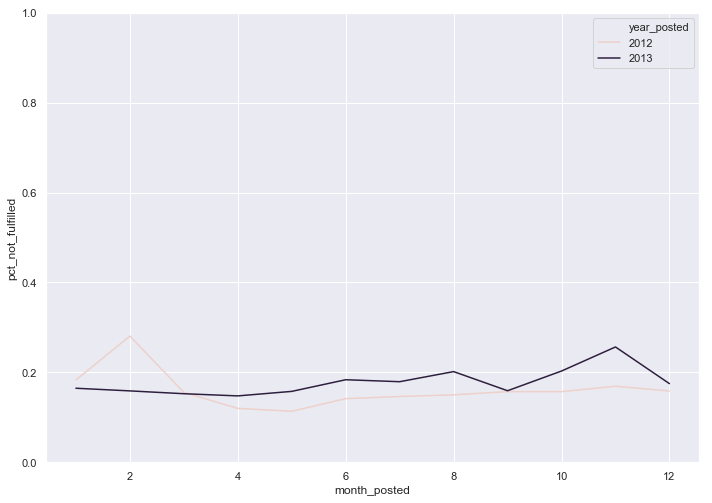

In [32]:
## See trend in unfunded rate per month for both 2012 and 2013 to see if there's yearly variation
sns.lineplot(x='month_posted', y='pct_not_fulfilled',hue='year_posted', data=tst2)
plt.ylim(0,1)

(0, 2000)

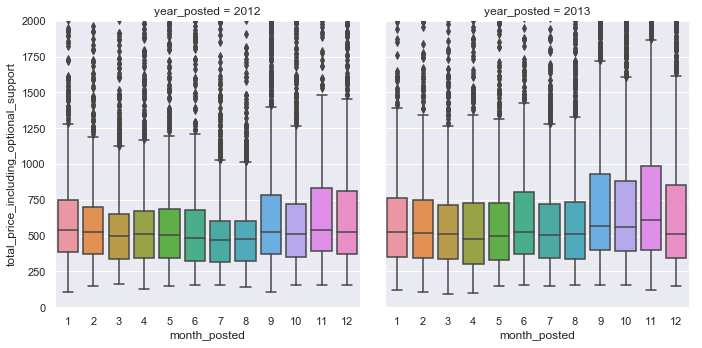

In [22]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.catplot(data=df, x="month_posted", y='total_price_including_optional_support', col='year_posted', kind='box')
plt.ylim(0,2000)

(0, 2000)

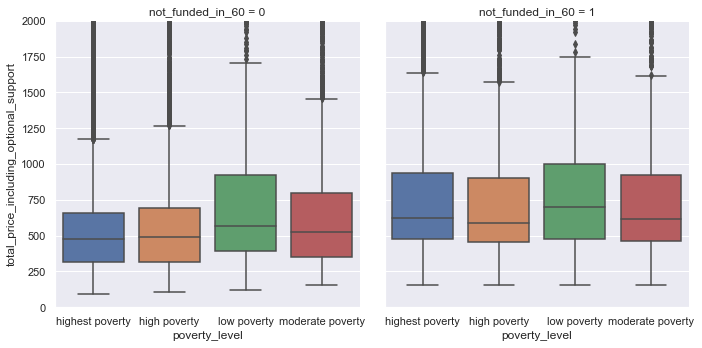

In [24]:
sns.catplot(data=df, x="poverty_level", y='total_price_including_optional_support', col='not_funded_in_60', kind='box')
plt.ylim(0,2000)

In [25]:
categoricals = ['school_charter','school_magnet', 'teacher_prefix', 'primary_focus_subject',
       'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area',
       'resource_type', 'grade_level']

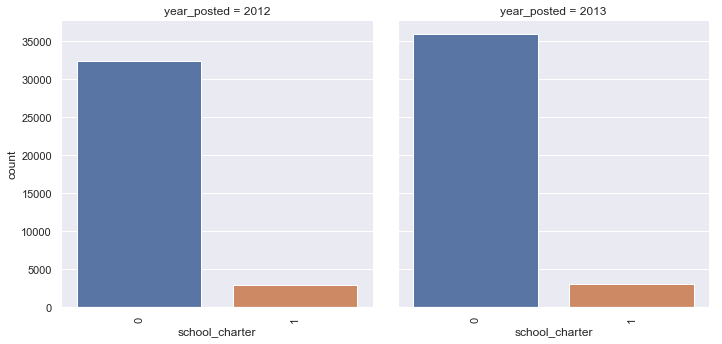

In [28]:
ax = sns.catplot(data=df, x='school_charter', col='year_posted', kind='count')
ax.set_xticklabels(rotation=90)


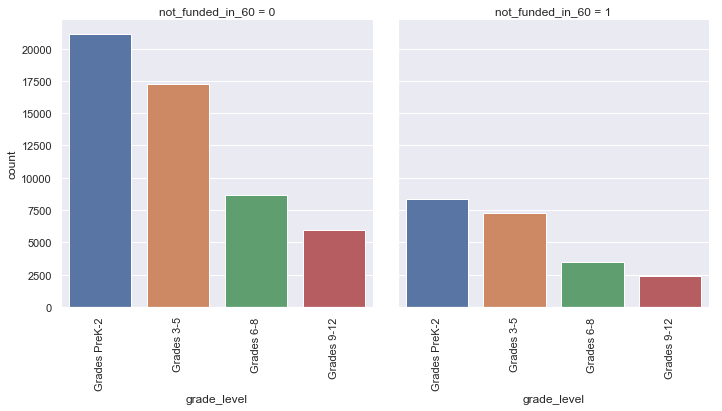

In [30]:
ax = sns.catplot(data=df, x='grade_level', col='not_funded_in_60', kind='count')
ax.set_xticklabels(rotation=90)

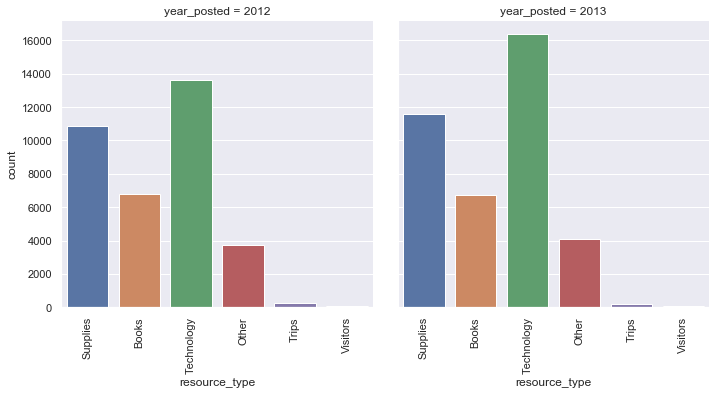

In [31]:
ax = sns.catplot(data=df, x='resource_type', col='year_posted', kind='count')
ax.set_xticklabels(rotation=90)

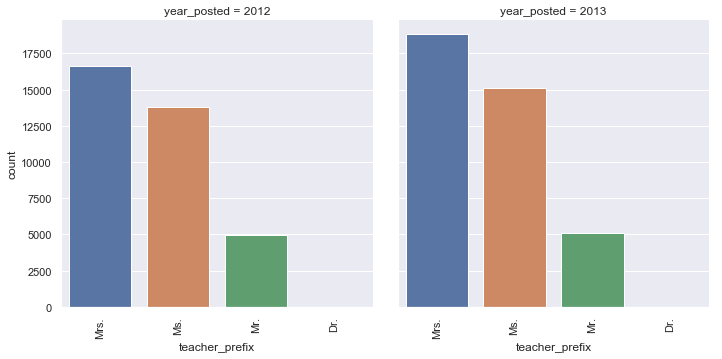

In [32]:
ax = sns.catplot(data=df, x='teacher_prefix', col='year_posted', kind='count')
ax.set_xticklabels(rotation=90)

### Feature Generation + Modeling

Within l.run_time_loop() I use get_time_periods() to create date boundaries for each train/test and use pipeline.get_train_test_splits()to create the datasets based on date the project was posted and the date boundaries. Within get_train_test_splits I create the features, identifying continuous and categorical columns, and impute missing data after separating train and test datasets. 

In [8]:
models_to_run = ['RF','DT','GB','LR','BG','SVM']
# runnning on modified grid so that it is able to complete
clfs, grid = l.define_clfs_params('small')

In [9]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [11]:
df_t = df.sample(frac=.5)

RF
DT
GB
LR
BG
SVM
RF
DT
GB


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

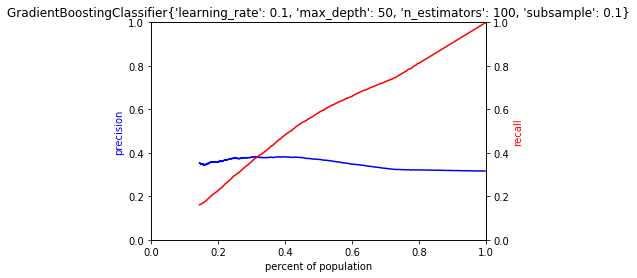

In [12]:
rv = l.run_time_loop(df_t, models_to_run, clfs, grid, [6], 'save')

In [14]:
rv

,train_start,train_end,test_start,test_end,model_type,clf,parameters,baseline,auc-roc,f1_at_5,...,p_at_20,p_at_30,p_at_50,r_at_1,r_at_2,r_at_5,r_at_10,r_at_20,r_at_30,r_at_50
0,2012-01-01,2012-06-30,2012-08-29,2013-02-27,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'n_estimators': 1, 'max_featu...",0.255913,0.522289,0.017857,...,0.013657,0.299292,0.372347,0.010664,0.010664,0.010664,0.010664,0.010664,0.350711,0.727488
1,2012-01-01,2012-06-30,2012-08-29,2013-02-27,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'n_estimators': 10, 'max_feat...",0.255913,0.590616,0.126984,...,0.347496,0.320526,0.307459,0.016588,0.036730,0.075829,0.129147,0.271327,0.375592,0.600711
2,2012-01-01,2012-06-30,2012-08-29,2013-02-27,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'n_estimators': 100, 'max_fea...",0.255913,0.635236,0.111111,...,0.373293,0.355915,0.332323,0.013033,0.024882,0.066351,0.135071,0.291469,0.417062,0.649289
3,2012-01-01,2012-06-30,2012-08-29,2013-02-27,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'n_estimators': 1000, 'max_fe...",0.255913,0.636296,0.103175,...,0.355083,0.355915,0.332323,0.016588,0.029621,0.061611,0.130332,0.277251,0.417062,0.649289
4,2012-01-01,2012-06-30,2012-08-29,2013-02-27,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'n_estimators': 1, 'max_featu...",0.255913,0.501496,0.059524,...,0.060698,0.154702,0.491207,0.005924,0.013033,0.035545,0.035545,0.047393,0.181280,0.959716
5,2012-01-01,2012-06-30,2012-08-29,2013-02-27,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'n_estimators': 10, 'max_feat...",0.255913,0.606025,0.099206,...,0.350531,0.352882,0.317162,0.009479,0.021327,0.059242,0.127962,0.273697,0.413507,0.619668
6,2012-01-01,2012-06-30,2012-08-29,2013-02-27,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'n_estimators': 100, 'max_fea...",0.255913,0.630193,0.103175,...,0.355083,0.350859,0.337174,0.011848,0.023697,0.061611,0.131517,0.277251,0.411137,0.658768
7,2012-01-01,2012-06-30,2012-08-29,2013-02-27,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'n_estimators': 1000, 'max_fe...",0.255913,0.630934,0.107143,...,0.356601,0.356926,0.328684,0.011848,0.028436,0.063981,0.137441,0.278436,0.418246,0.642180
8,2012-01-01,2012-06-30,2012-08-29,2013-02-27,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 10, 'n_estimators': 1, 'max_feat...",0.255913,0.548009,0.051587,...,0.232170,0.306370,0.281989,0.003555,0.017773,0.030806,0.127962,0.181280,0.359005,0.550948
9,2012-01-01,2012-06-30,2012-08-29,2013-02-27,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 10, 'n_estimators': 10, 'max_fea...",0.255913,0.618213,0.123016,...,0.344461,0.343782,0.322620,0.016588,0.029621,0.073460,0.140995,0.268957,0.402844,0.630332


In [15]:
rv['auc-roc'].max()

0.6117332872278521

rv.sort_values('f1_at_10',ascending=False).loc[:,['train_start','train_end','model_type','auc-roc','baseline','f1_at_5','f1_at_10','a_at_5','a_at_10','p_at_10','p_at_50','r_at_10','r_at_50']]

In [18]:
rv.sort_values('p_at_10',ascending=False).loc[:,['train_start','train_end','model_type','auc-roc','baseline','f1_at_5','f1_at_10','a_at_5', 'a_at_10','a_at_20','a_at_30','a_at_50',
                                            'p_at_1', 'p_at_2', 'p_at_5', 'p_at_10', 'p_at_20', 'p_at_30', 'p_at_50','p_at_10','p_at_50','r_at_10','r_at_50']]

,train_start,train_end,model_type,auc-roc,baseline,f1_at_5,f1_at_10,a_at_5,a_at_10,a_at_20,...,p_at_2,p_at_5,p_at_10,p_at_20,p_at_30,p_at_50,p_at_10,p_at_50,r_at_10,r_at_50
67,2012-01-01,2012-12-30,BG,0.602236,not_funded_in_60 0.314213 dtype: float64,0.125145,0.240326,0.681569,0.685365,0.663011,...,0.553191,0.457627,0.497890,0.443038,0.405063,0.378903,0.497890,0.378903,0.158389,0.602685
68,2012-01-01,2012-12-30,BG,0.599160,not_funded_in_60 0.314213 dtype: float64,0.129780,0.240326,0.683256,0.685365,0.663011,...,0.340426,0.474576,0.497890,0.443038,0.407876,0.374684,0.497890,0.374684,0.158389,0.595973
69,2012-01-01,2012-12-30,SVM,0.602303,not_funded_in_60 0.314213 dtype: float64,0.139050,0.236253,0.686630,0.683678,0.663855,...,0.531915,0.508475,0.489451,0.445148,0.414909,0.372996,0.489451,0.372996,0.155705,0.593289
62,2012-01-01,2012-12-30,LR,0.603589,not_funded_in_60 0.314213 dtype: float64,0.136732,0.234216,0.685787,0.682834,0.664698,...,0.531915,0.500000,0.485232,0.447257,0.414909,0.373840,0.485232,0.373840,0.154362,0.594631
60,2012-01-01,2012-12-30,LR,0.605837,not_funded_in_60 0.314213 dtype: float64,0.129780,0.228106,0.683256,0.680304,0.668916,...,0.489362,0.474576,0.472574,0.457806,0.427567,0.378903,0.472574,0.378903,0.150336,0.602685
64,2012-01-01,2012-12-30,BG,0.581981,not_funded_in_60 0.314213 dtype: float64,0.134415,0.221996,0.684943,0.677773,0.652046,...,0.510638,0.491525,0.459916,0.415612,0.383966,0.361181,0.459916,0.361181,0.146309,0.574497
132,2012-01-01,2012-12-31,LR,0.598168,not_funded_in_60 0.290579 dtype: float64,0.134715,0.231360,0.705363,0.699894,0.669725,...,0.495575,0.459364,0.452297,0.400706,0.375882,0.348977,0.452297,0.348977,0.155434,0.600486
61,2012-01-01,2012-12-30,LR,0.595739,not_funded_in_60 0.314213 dtype: float64,0.129780,0.217923,0.683256,0.676086,0.664698,...,0.468085,0.474576,0.451477,0.447257,0.410689,0.371308,0.451477,0.371308,0.143624,0.590604
66,2012-01-01,2012-12-30,BG,0.587402,not_funded_in_60 0.314213 dtype: float64,0.125145,0.217923,0.681569,0.676086,0.653733,...,0.510638,0.457627,0.451477,0.419831,0.395218,0.372996,0.451477,0.372996,0.143624,0.593289
130,2012-01-01,2012-12-31,LR,0.605054,not_funded_in_60 0.290579 dtype: float64,0.131606,0.230456,0.704305,0.699541,0.675018,...,0.460177,0.448763,0.450530,0.413945,0.381176,0.349682,0.450530,0.349682,0.154827,0.601700


In [23]:
rv[rv['auc-roc'] == rv['auc-roc'].max()]

,train_start,train_end,test_start,test_end,model_type,clf,parameters,baseline,auc-roc,f1_at_5,...,p_at_20,p_at_30,p_at_50,r_at_1,r_at_2,r_at_5,r_at_10,r_at_20,r_at_30,r_at_50
88,2012-01-01,2013-06-30,2013-08-29,2014-02-27,GB,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",not_funded_in_60 0.273943 dtype: float64,0.611733,0.142723,...,0.398782,0.365112,0.340024,0.013319,0.034406,0.084351,0.152053,0.290788,0.399556,0.620422
